# Calculation of control fields for QFT gate on two qubits using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.create_pulse_optimizer function to 
generate an Optimizer object, through which the configuration can be
manipulated before running the optmisation algorithm. In this case it is
demonstrated by modifying the initial ctrl pulses. Also re-uses objects in repeated runs with different total evolution times.

The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which is equivalent maximising the fidelity
to optimal value of 1.

The system in this example is two qubits in constant fields in x, y and z
with variable independant controls fields in x and y acting on each qubit
The target evolution is the QFT gate. The user can experiment with the
different:
 * evolution times - evo_times list values, try anything 
 * phase options - phase_option = SU or PSU
 *  propagtor computer type prop_type = DIAG or FRECHET
 *  fidelity measures - fid_type = UNIT or TRACEDIFF

The user can experiment with the timeslicing, by means of changing the
timeslots durations.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

This example assumes that the example-control-pulseoptim-Hadamard has already been tried, and hence explanations in that notebook are not repeated here.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np

import qutip_qtrl.pulsegen as pulsegen

import qutip_qtrl.pulseoptim as cpo
from qutip import identity, sigmax, sigmay, sigmaz, tensor, about
from qutip_qip.algorithms import qft

example_name = "QFT"

%matplotlib inline

### Defining the physics

Note here that there are two controls acting on each qubit.

In [2]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = 0.5 * identity(2)

# Drift Hamiltonian
H_d = 0.5 * (tensor(Sx, Sx) + tensor(Sy, Sy) + tensor(Sz, Sz))
# The (four) control Hamiltonians
H_c = [tensor(Sx, Si), tensor(Sy, Si), tensor(Si, Sx), tensor(Si, Sy)]
n_ctrls = len(H_c)
# start point for the gate evolution
U_0 = identity(4)
# Target for the gate evolution - Quantum Fourier Transform gate
U_targ = qft(2)

### Defining the time evolution parameters

Multiple total evolution times will be tried. Using this approach, the minimum evolution time required to achieve the target fidelity could be determined (iteratively).

Note that the timeslot duration dt is fixed, and so the number of timeslots depends on the evo_time

In [3]:
# Duration of each timeslot
dt = 0.05
# List of evolution times to try
evo_times = [1, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = int(float(evo_time) / dt)
# Empty list that will hold the results for each evolution time
results = list()

### Set the conditions which will cause the pulse optimisation to terminate

In [4]:
# Fidelity error target
fid_err_targ = 1e-5
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

Here the linear initial pulse type is used, simply because it results in smooth final pulses

In [5]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "LIN"

### Give an extension for output files

In [6]:
# Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Create the optimiser objects

Here is the main difference between this and the Hadamard example. In this case we use a different pulseoptim function that just creates the objects that can be used to set the physics and configure the optimisation algorithm. This gives greater flexibility (shown here by seting different initial pulse parameters for each control) and is also more efficient when running multiple optimisations on the same system.

In [7]:
optim = cpo.create_pulse_optimizer(
    H_d,
    H_c,
    U_0,
    U_targ,
    n_ts,
    evo_time,
    amp_lbound=-5.0,
    amp_ubound=5.0,
    fid_err_targ=fid_err_targ,
    min_grad=min_grad,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    optim_method="fmin_l_bfgs_b",
    method_params={"max_metric_corr": 20, "accuracy_factor": 1e8},
    dyn_type="UNIT",
    fid_params={"phase_option": "PSU"},
    init_pulse_type=p_type,
    gen_stats=True,
)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
p_gen = optim.pulse_generator

### Optimise the pulse for each of the different evolution times

Here a loop is used to perform the optimisation for each of the evo_times given in the list above. The first optimisation is completed using the timeslot parameters passed when the optimisation objects are created. For the subsequent runs, the Dynamics object 'dyn' is used to set the timeslot parameters before the initial pulses are generated and optimisation is completed. Note that using this method, the dyn.initialize_controls method must be called with an array of the initial amplitudes before the optim.run_optimization method is called.

In [8]:
for i in range(n_evo_times):
    # Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
    dyn.init_timeslots()
    if i > 0:
        # Create a new pulse generator for the new dynamics
        p_gen = pulsegen.create_pulse_gen(p_type, dyn)

    # Generate different initial pulses for each of the controls
    init_amps = np.zeros([n_ts, n_ctrls])
    if p_gen.periodic:
        phase_diff = np.pi / n_ctrls
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse(start_phase=phase_diff * j)
    elif isinstance(p_gen, pulsegen.PulseGenLinear):
        for j in range(n_ctrls):
            p_gen.scaling = float(j) - float(n_ctrls - 1) / 2
            init_amps[:, j] = p_gen.gen_pulse()
    elif isinstance(p_gen, pulsegen.PulseGenZero):
        for j in range(n_ctrls):
            p_gen.offset = sf = float(j) - float(n_ctrls - 1) / 2
            init_amps[:, j] = p_gen.gen_pulse()
    else:
        # Should be random pulse
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse()

    dyn.initialize_controls(init_amps)

    # Save initial amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_initial_" + f_ext
        dyn.save_amps(pulsefile)
        print("Initial amplitudes output to file: " + pulsefile)

    print("***********************************")
    print("\n+++++++++++++++++++++++++++++++++++")
    print("Starting pulse optimisation for T={}".format(evo_time))
    print("+++++++++++++++++++++++++++++++++++\n")
    result = optim.run_optimization()
    results.append(result)

    # Save final amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_final_" + f_ext
        dyn.save_amps(pulsefile)
        print("Final amplitudes output to file: " + pulsefile)

    # Report the results
    result.stats.report()
    print("Final evolution\n{}\n".format(result.evo_full_final))
    print("********* Summary *****************")
    print("Final fidelity error {}".format(result.fid_err))
    print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
    print("Number of iterations {}".format(result.num_iter))
    print(
        "Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=result.wall_time)
        )
    )

    if i + 1 < len(evo_times):
        # reconfigure the dynamics for the next evo time
        evo_time = evo_times[i + 1]
        n_ts = int(float(evo_time) / dt)
        dyn.tau = None
        dyn.evo_time = evo_time
        dyn.num_tslots = n_ts

Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts20_ptypeLIN.txt
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=1
+++++++++++++++++++++++++++++++++++



Final amplitudes output to file: ctrl_amps_final_QFT_n_ts20_ptypeLIN.txt

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.255390
Wall time computing Hamiltonians: 0:00:00.019020 (7.45%)
Wall time computing propagators: 0:00:00.184145 (72.10%)
Wall time computing forward propagation: 0:00:00.001614 (0.63%)
Wall time computing onward propagation: 0:00:00.001594 (0.62%)
Wall time computing gradient: 0:00:00.034511 (13.51%)

**** Iterations and function calls ****
Number of iterations: 62
Number of fidelity function calls: 70
Number of times fidelity is computed: 70
Number of gradient function calls: 70
Number of times gradients are computed: 70
Number of times timeslot evolution is recomputed: 70

**** Control amplitudes ****
Number of control amplitude updates: 69
Mean number of updates per iteration: 1.1129032258064515
Number of timeslot values changed: 731
Mean number of times

Final amplitudes output to file: ctrl_amps_final_QFT_n_ts20_ptypeLIN.txt

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.380312
Wall time computing Hamiltonians: 0:00:00.029239 (7.69%)
Wall time computing propagators: 0:00:00.284048 (74.69%)
Wall time computing forward propagation: 0:00:00.002470 (0.65%)
Wall time computing onward propagation: 0:00:00.002404 (0.63%)
Wall time computing gradient: 0:00:00.052067 (13.69%)

**** Iterations and function calls ****
Number of iterations: 29
Number of fidelity function calls: 36
Number of times fidelity is computed: 36
Number of gradient function calls: 35
Number of times gradients are computed: 35
Number of times timeslot evolution is recomputed: 36

**** Control amplitudes ****
Number of control amplitude updates: 35
Mean number of updates per iteration: 1.206896551724138
Number of timeslot values changed: 2100
Mean number of times

Final amplitudes output to file: ctrl_amps_final_QFT_n_ts20_ptypeLIN.txt

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.619521
Wall time computing Hamiltonians: 0:00:00.047678 (7.70%)
Wall time computing propagators: 0:00:00.465055 (75.07%)
Wall time computing forward propagation: 0:00:00.004032 (0.65%)
Wall time computing onward propagation: 0:00:00.003804 (0.61%)
Wall time computing gradient: 0:00:00.081291 (13.12%)

**** Iterations and function calls ****
Number of iterations: 24
Number of fidelity function calls: 30
Number of times fidelity is computed: 30
Number of gradient function calls: 29
Number of times gradients are computed: 29
Number of times timeslot evolution is recomputed: 30

**** Control amplitudes ****
Number of control amplitude updates: 29
Mean number of updates per iteration: 1.2083333333333333
Number of timeslot values changed: 3480
Mean number of time

### Plot the initial and final amplitudes

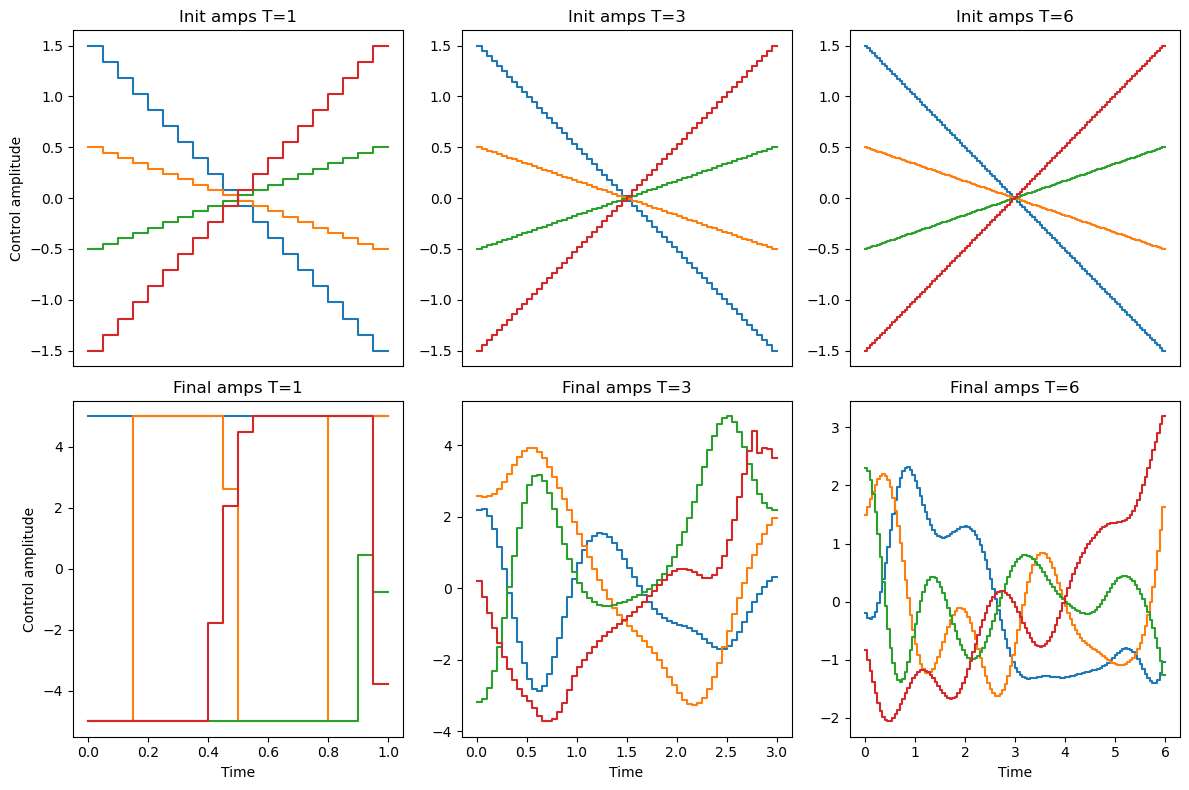

In [9]:
fig1 = plt.figure(figsize=(12, 8))
for i in range(n_evo_times):
    # Initial amps
    ax1 = fig1.add_subplot(2, n_evo_times, i + 1)
    ax1.set_title("Init amps T={}".format(evo_times[i]))
    # ax1.set_xlabel("Time")
    ax1.get_xaxis().set_visible(False)
    if i == 0:
        ax1.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax1.step(
            results[i].time,
            np.hstack((results[i].initial_amps[:, j], results[i].initial_amps[-1, j])),
            where="post",
        )

    ax2 = fig1.add_subplot(2, n_evo_times, i + n_evo_times + 1)
    ax2.set_title("Final amps T={}".format(evo_times[i]))
    ax2.set_xlabel("Time")
    # Optimised amps
    if i == 0:
        ax2.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax2.step(
            results[i].time,
            np.hstack((results[i].final_amps[:, j], results[i].final_amps[-1, j])),
            where="post",
        )

plt.tight_layout()
plt.show()

### Versions

In [10]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
